In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from ptracking.database import cursor
from pathlib import Path

font = {'size'   : 12}

matplotlib.rc('font', **font)
plt.rcParams['text.usetex'] = True

img_path = Path("img").absolute()

# with cursor() as cur:
#     cur.execute("Select state, count(*) from petition group by state")
#     res = cur.fetchall()

# df = pd.DataFrame(res, columns=["state", "count"])

# plt.ylabel("Petition State")
# plt.xlabel("Number of Petitions")
# plt.grid(axis="x")
# # plt.tight_layout()
# plt.barh(y=df["state"], width=df["count"])
# plt.savefig(img_path.joinpath("states.pdf"))

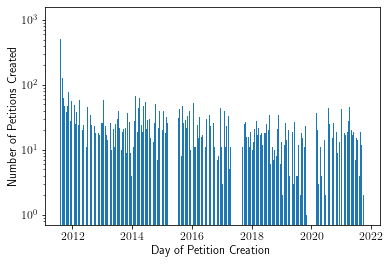

In [8]:
with cursor() as cur:
    cur.execute("SELECT date_trunc('day', created_at) as day, count(*) from petition group by day")
    res = cur.fetchall()

df_dates = pd.DataFrame(res, columns=["created_day", "no"])
fig, ax = plt.subplots()
ax.bar(df_dates.created_day, df_dates.no, width=1)
plt.yscale("log")
plt.xlabel("Day of Petition Creation")
plt.ylabel("Number of Petitions Created")
plt.savefig(img_path.joinpath("petitions_created_over_time.pdf"))

In [9]:
# with cursor() as cur:
#     cur.execute("SELECT date_trunc('hour', created_at) as date, signatures from petition order by date asc")
#     res = cur.fetchall()

# df_signatures = pd.DataFrame(res, columns=["created", "signatures"])
# print(df_signatures)
# fig, ax = plt.subplots()
# ax.bar(df_signatures.created, df_signatures.signatures)
# plt.xlabel("Petition Creation Date")
# plt.ylabel("Number of Signatures")
# plt.savefig(img_path.joinpath("signatures_created_over_time.pdf"))

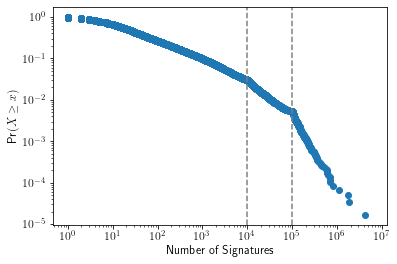

In [10]:
with cursor() as cur:
    cur.execute("SELECT signatures from petition order by created_at asc")
    res = cur.fetchall()

df_signatures = pd.DataFrame(res, columns=["signatures"])
signatures = df_signatures.signatures.sort_values()
y = 1- (1. * np.arange(len(signatures)) / (len(signatures) - 1))
plt.xscale("log")
plt.yscale("log")
plt.axvline(10_000, c="grey", linestyle="--")
plt.axvline(100_000, c="grey", linestyle="--")
plt.xlabel("Number of Signatures")
plt.ylabel(r"$\mathsf{Pr}(X \ge x)$")
plt.scatter(signatures, y)
plt.savefig(img_path.joinpath("complementary_cdf.png"), dpi=1200)

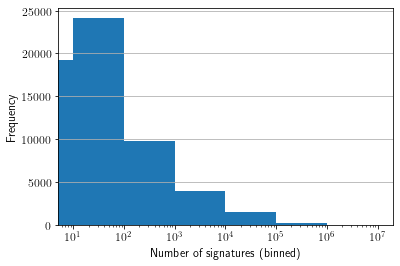

In [11]:
from ptracking.predict import Dataset
from ptracking.predict.evaluator import DEFAULT_BINS

data = Dataset().prepare(["created_at"])
plt.xscale("log")
plt.grid(axis="y")
plt.hist(data.signatures, bins=DEFAULT_BINS)
plt.xlabel("Number of signatures (binned)")
plt.ylabel("Frequency")
plt.savefig(img_path.joinpath("binned_signature_count.pdf"))

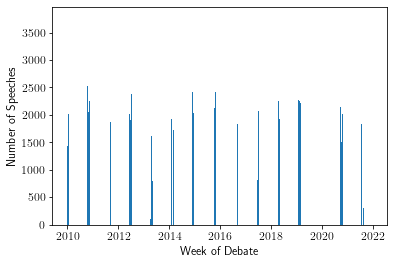

In [12]:
with cursor() as cur:
    cur.execute("select date_trunc('week', date) as week, count(*) from debate group by week")
    res = cur.fetchall()

debates = pd.DataFrame(res, columns=["week", "count_"])
debates
plt.bar(debates.week, debates.count_, width=1)
plt.xlabel("Week of Debate")
plt.ylabel("Number of Speeches")
plt.savefig(img_path.joinpath("debates_over_time.png"), dpi=1200)


In [13]:
from scipy.stats import pearsonr
from ptracking.twitter_scraper.twitter_scraper import TwitterFetcher
from ptracking.database import Fetcher

tweets = TwitterFetcher.select_tweet_count()
signs = Fetcher.select_columns("signatures")

tweets_df = signs.join(tweets)
tweets_df

AttributeError: type object 'Fetcher' has no attribute 'select_closed'

(0.6899097395657554, 0.0)


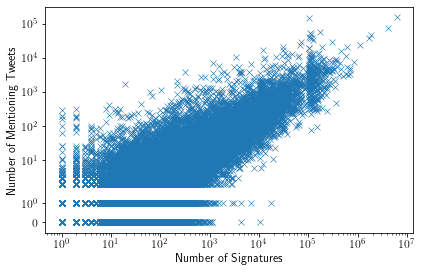

In [ ]:
print(pearsonr(tweets_df.signatures, tweets_df['count']))
plt.xlabel("Number of Signatures")
plt.xscale("log")
plt.yscale("symlog")

# plt.ticklabel_format(axis='y', style="sci", scilimits=(0, 0))
plt.ylabel("Number of Mentioning Tweets")
plt.tight_layout()
plt.scatter(tweets_df.signatures, tweets_df['count'], marker="x", linewidths=0.6)
plt.savefig(img_path.joinpath("signatures_vs_tweets.pdf"))

/tmp/ipykernel_999/172857933.py:14: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.imshow(heatmap.T, extent=extent, origin='lower')


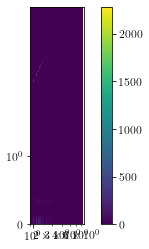

In [ ]:
from matplotlib.colors import LogNorm
# ss = (tweets_df.signatures - tweets_df.signatures.mean()) / tweets_df.signatures.std()
# twts = (tweets_df['count'] - tweets_df['count'].mean()) / tweets_df['count'].std()
# ss = tweets_df.signatures
# twts = tweets_df['count']
ss = np.log10(tweets_df.signatures)
twts = np.log10(tweets_df['count'], where=tweets_df['count'] > 0)

heatmap, xedges, yedges = np.histogram2d(ss, twts, bins=(1000, 100))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.xscale("log")
plt.yscale("symlog")
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.colorbar()

In [ ]:
with cursor() as cur:
    cur.execute("""select petition_id, count(debate_id) 
                from petition left join debate on
                    (created_at - INTERVAL '7 days' < date AND created_at + INTERVAL '7 days' > date)
                group by petition_id"""
    )
    speeches = cur.fetchall()
    cur.execute("""select petition_id, count(debate_id) 
                from petition left join (select distinct debate_id, date from debate) debate  on
                    (created_at - INTERVAL '7 days' < debate.date AND created_at + INTERVAL '7 days' > debate.date)
                group by petition_id"""
    )
    debates = cur.fetchall()

df_speeches = pd.DataFrame(speeches, columns=["petition_id", "speeches_within_week"])
df_debates = pd.DataFrame(debates, columns=["petition_id", "debates_within_week"])

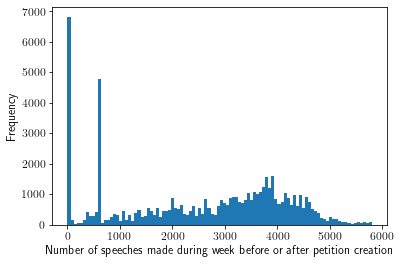

In [ ]:
plt.xlabel("Number of speeches made during week before or after petition creation")
plt.ylabel("Frequency")
plt.hist(df_speeches.speeches_within_week, bins=100)
plt.savefig(img_path.joinpath("speeches_within_week.pdf"))

(array([12384.,   985.,  1194.,  1159.,  1927.,  1953.,  2002.,  2069.,
         3056.,  4287.,  3797.,  3552.,  3722.,  3315.,  3418.,  2663.,
         2019.,  1578.,  1005.,  1336.,   631.,   383.,   308.,   157.,
          130.]),
 array([ 0.  ,  1.04,  2.08,  3.12,  4.16,  5.2 ,  6.24,  7.28,  8.32,
         9.36, 10.4 , 11.44, 12.48, 13.52, 14.56, 15.6 , 16.64, 17.68,
        18.72, 19.76, 20.8 , 21.84, 22.88, 23.92, 24.96, 26.  ]),
 <BarContainer object of 25 artists>)

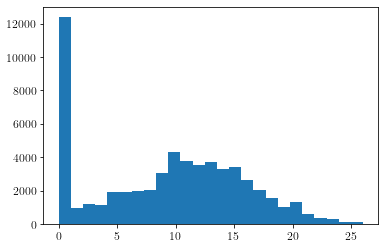

In [ ]:
plt.hist(df_debates.debates_within_week, bins=25)